<a href="https://colab.research.google.com/github/run-llama/llama_index/blob/main/docs/docs/examples/multi_modal/gpt4v_multi_modal_retrieval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Multi-Modal Retrieval using GPT4V and Multi-Modal Index/Retriever

In this notebook, we show how to build a Multi-Modal retrieval system using LlamaIndex with GPT4-V and CLIP.

LlamaIndex Multi-Modal Retrieval 

- Text embedding index: Generate GPT text embeddings
- Images embedding index: [CLIP](https://github.com/openai/CLIP) embeddings from OpenAI for images


Encoding queries:
* Encode query text for text index using ada
* Encode query text for image index using CLIP

Framework: [LlamaIndex](https://github.com/run-llama/llama_index)

Steps:
1. Using Multi-Modal LLM GPT4V class to undertand multiple images
2. Download texts, images, pdf raw files from related Wikipedia articles and SEC 10K report
2. Build Multi-Modal index and vetor store for both texts and images
4. Retrieve relevant text and image simultaneously using Multi-Modal Retriver according to the image reasoning from Step 1

In [ ]:
%pip install llama-index-multi-modal-llms-openai
%pip install llama-index-vector-stores-qdrant

In [ ]:
%pip install llama_index ftfy regex tqdm
%pip install git+https://github.com/openai/CLIP.git
%pip install torch torchvision
%pip install matplotlib scikit-image
%pip install -U qdrant_client

In [ ]:
import os

OPENAI_API_KEY = ""
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

## Download images from Tesla website for GPT4V image reasoning

In [ ]:
from pathlib import Path

input_image_path = Path("input_images")
if not input_image_path.exists():
    Path.mkdir(input_image_path)

In [ ]:
!wget "https://docs.google.com/uc?export=download&id=1nUhsBRiSWxcVQv8t8Cvvro8HJZ88LCzj" -O ./input_images/long_range_spec.png
!wget "https://docs.google.com/uc?export=download&id=19pLwx0nVqsop7lo0ubUSYTzQfMtKJJtJ" -O ./input_images/model_y.png
!wget "https://docs.google.com/uc?export=download&id=1utu3iD9XEgR5Sb7PrbtMf1qw8T1WdNmF" -O ./input_images/performance_spec.png
!wget "https://docs.google.com/uc?export=download&id=1dpUakWMqaXR4Jjn1kHuZfB0pAXvjn2-i" -O ./input_images/price.png
!wget "https://docs.google.com/uc?export=download&id=1qNeT201QAesnAP5va1ty0Ky5Q_jKkguV" -O ./input_images/real_wheel_spec.png

## Generate image reasoning from GPT4V Multi-Modal LLM

### Plot input images

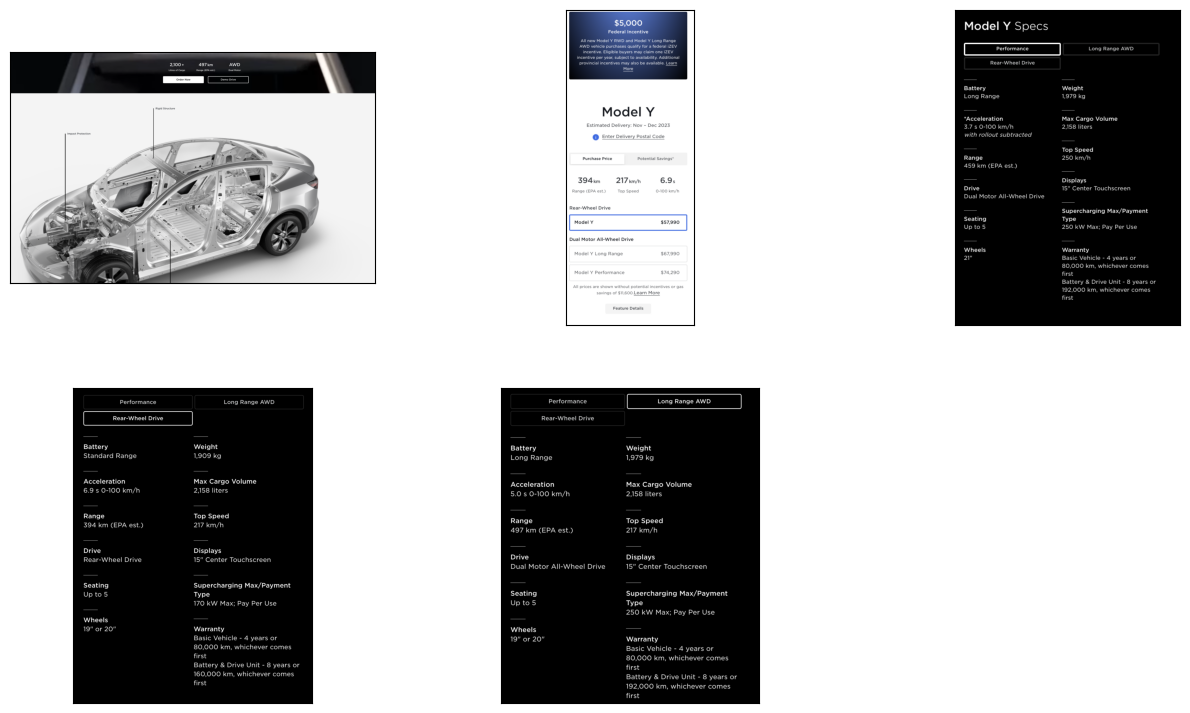

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import os

image_paths = []
for img_path in os.listdir("./input_images"):
    image_paths.append(str(os.path.join("./input_images", img_path)))


def plot_images(image_paths):
    images_shown = 0
    plt.figure(figsize=(16, 9))
    for img_path in image_paths:
        if os.path.isfile(img_path):
            image = Image.open(img_path)

            plt.subplot(2, 3, images_shown + 1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])

            images_shown += 1
            if images_shown >= 9:
                break


plot_images(image_paths)

### Using GPT4V to understand those input images

In [ ]:
from llama_index.multi_modal_llms.openai import OpenAIMultiModal
from llama_index.core import SimpleDirectoryReader

# put your local directore here
image_documents = SimpleDirectoryReader("./input_images").load_data()

openai_mm_llm = OpenAIMultiModal(
    model="gpt-4o", api_key=OPENAI_API_KEY, max_new_tokens=1500
)

response_1 = openai_mm_llm.complete(
    prompt="Describe the images as an alternative text",
    image_documents=image_documents,
)

print(response_1)

The images depict information and specifications about electric vehicles, presumably from a car manufacturer's website.

Image 1:
This image contains text that lists specifications for two different car models, one with Rear-Wheel Drive and the other with Long Range AWD (All-Wheel Drive). Categories covered include Battery, Weight, Acceleration, Range, Top Speed, Drive, Seating, Wheels, and Warranty.

Image 2:
This image shows a cutaway illustration of an electric vehicle highlighting its structural components. The car is rendered to show its internal features such as rigid structure and impact protection zones.

Image 3:
Similar to the first image, this image contains text showing specifications for two variants of what appears to be the same model of electric vehicle, with one being a performance model and the other Long Range AWD. The specs include Battery, Acceleration, Range, Drive, Seating, Wheels, Display, Tire Type, Supercharging Max/Power, and Warranty.

Image 4:
The image pre

In [ ]:
response_2 = openai_mm_llm.complete(
    prompt="Can you tell me what is the price with each spec?",
    image_documents=image_documents,
)

print(response_2)

The images you've provided appear to be from a car manufacturer's website, showing different specifications for an electric vehicle and the associated prices for different trim levels or configurations of the vehicle. However, since the actual text content for the price per specification is not fully legible in the images provided, I can't give you precise pricing information. Generally, these types of websites often list the following trims with increasing features and therefore increasing prices:

1. Rear-Wheel Drive (Standard Range or Long Range)
2. Dual Motor All-Wheel Drive (often dubbed Long Range AWD)
3. Performance (typically comes with the most features and fastest acceleration)

Features like acceleration times, range, top speed, curb weight, cargo volume, seating capacity, display type, drive type, wheels size, warranty, and others can vary by trim level. The images show that there are different specs for the "Performance" and "Long Range AWD" trims such as acceleration, ran

## Generating text, pdf, images data from raw files [Wikipedia, SEC files] for Multi Modal Index/Retrieval

In [ ]:
import requests


def get_wikipedia_images(title):
    response = requests.get(
        "https://en.wikipedia.org/w/api.php",
        params={
            "action": "query",
            "format": "json",
            "titles": title,
            "prop": "imageinfo",
            "iiprop": "url|dimensions|mime",
            "generator": "images",
            "gimlimit": "50",
        },
    ).json()
    image_urls = []
    for page in response["query"]["pages"].values():
        if page["imageinfo"][0]["url"].endswith(".jpg") or page["imageinfo"][
            0
        ]["url"].endswith(".png"):
            image_urls.append(page["imageinfo"][0]["url"])
    return image_urls

In [ ]:
from pathlib import Path
import requests
import urllib.request

image_uuid = 0
# image_metadata_dict stores images metadata including image uuid, filename and path
image_metadata_dict = {}
MAX_IMAGES_PER_WIKI = 20

wiki_titles = {
    "Tesla Model Y",
    "Tesla Model X",
    "Tesla Model 3",
    "Tesla Model S",
    "Kia EV6",
    "BMW i3",
    "Audi e-tron",
    "Ford Mustang",
    "Porsche Taycan",
    "Rivian",
    "Polestar",
}


data_path = Path("mixed_wiki")
if not data_path.exists():
    Path.mkdir(data_path)

for title in wiki_titles:
    response = requests.get(
        "https://en.wikipedia.org/w/api.php",
        params={
            "action": "query",
            "format": "json",
            "titles": title,
            "prop": "extracts",
            "explaintext": True,
        },
    ).json()
    page = next(iter(response["query"]["pages"].values()))
    wiki_text = page["extract"]

    with open(data_path / f"{title}.txt", "w") as fp:
        fp.write(wiki_text)

    images_per_wiki = 0
    try:
        # page_py = wikipedia.page(title)
        list_img_urls = get_wikipedia_images(title)
        # print(list_img_urls)

        for url in list_img_urls:
            if (
                url.endswith(".jpg")
                or url.endswith(".png")
                or url.endswith(".svg")
            ):
                image_uuid += 1
                # image_file_name = title + "_" + url.split("/")[-1]

                urllib.request.urlretrieve(
                    url, data_path / f"{image_uuid}.jpg"
                )
                images_per_wiki += 1
                # Limit the number of images downloaded per wiki page to 15
                if images_per_wiki > MAX_IMAGES_PER_WIKI:
                    break
    except:
        print(str(Exception("No images found for Wikipedia page: ")) + title)
        continue

In [ ]:
!wget "https://www.dropbox.com/scl/fi/mlaymdy1ni1ovyeykhhuk/tesla_2021_10k.htm?rlkey=qf9k4zn0ejrbm716j0gg7r802&dl=1" -O ./mixed_wiki/tesla_2021_10k.htm

## Build Multi-modal index and vector store to index both text and images

In [ ]:
from llama_index.core.indices import MultiModalVectorStoreIndex
from llama_index.vector_stores.qdrant import QdrantVectorStore
from llama_index.core import SimpleDirectoryReader, StorageContext

import qdrant_client
from llama_index.core import SimpleDirectoryReader


# Create a local Qdrant vector store
client = qdrant_client.QdrantClient(path="qdrant_mm_db")

text_store = QdrantVectorStore(
    client=client, collection_name="text_collection"
)
image_store = QdrantVectorStore(
    client=client, collection_name="image_collection"
)
storage_context = StorageContext.from_defaults(
    vector_store=text_store, image_store=image_store
)

# Create the MultiModal index
documents = SimpleDirectoryReader("./mixed_wiki/").load_data()
index = MultiModalVectorStoreIndex.from_documents(
    documents,
    storage_context=storage_context,
)

# Save it
# index.storage_context.persist(persist_dir="./storage")

# # Load it
from llama_index.core import load_index_from_storage

# storage_context = StorageContext.from_defaults(
#     vector_store=text_store, persist_dir="./storage"
# )
# index = load_index_from_storage(storage_context, image_store=image_store)

In [ ]:
print(response_2.text)

## Retrieve and query texts and images from our Multi-Modal Index

We show two examples leveraging multi-modal retrieval.

1. **Retrieval-Augmented Captioning**: In the first example, we perform multi-modal retrieval based on an existing image caption, to return more relevant context. We can then continue to query the LLM for related vehicles.
2. **Multi-modal RAG Querying**: In the second example, given a user-query, we first retrieve a mix of both text and images, and feed it to an LLM for synthesis.


### 1. Retrieval-Augmented Captioning

In [ ]:
# generate Text retrieval results
MAX_TOKENS = 50
retriever_engine = index.as_retriever(
    similarity_top_k=3, image_similarity_top_k=3
)
# retrieve more information from the GPT4V response
retrieval_results = retriever_engine.retrieve(response_2.text[:MAX_TOKENS])

**Node ID:** 8a67ab30-545c-46ee-a25f-64c95a4571be<br>**Similarity:** 0.7758026357212682<br>**Text:** == Reception ==
Consumer Reports wrote that the all-wheel-drive Model X 90D largely disappoints, as rear doors are prone to pausing and stopping, the second-row seats that cannot be folded, and the...<br>

**Node ID:** 5db1e928-197d-41d4-b1c1-34d2bcf1cc4d<br>**Similarity:** 0.7712850768830459<br>**Text:** == Design and technology ==


=== Body and chassis ===
The i3 was the first mass production car with most of its internal structure and body made of carbon-fiber reinforced plastic (CFRP). BMW took...<br>

**Node ID:** 89e533c6-3e25-4933-b58a-7d42ac67e957<br>**Similarity:** 0.768609543932987<br>**Text:** === Autoshift ===
Introduced in mid-2021, the Plaid and Long Range versions of the Model S feature no steering column-mounted shift stalk; instead, the Model S uses cameras to infer whether to shif...<br>

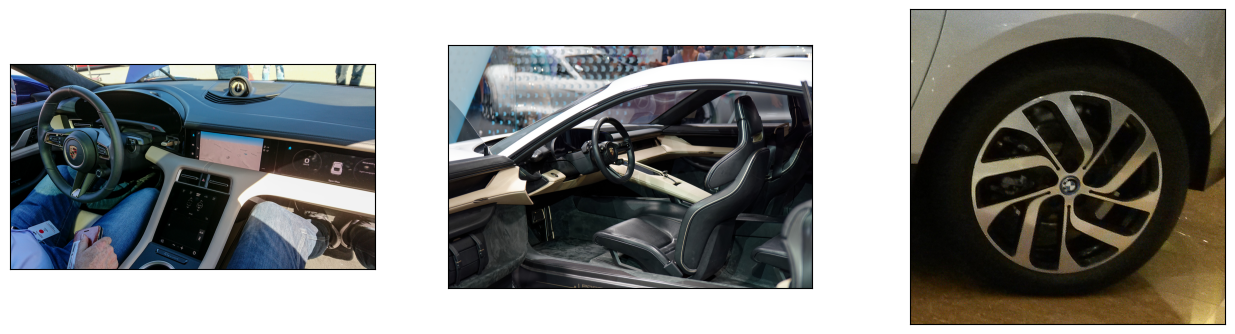

In [ ]:
from llama_index.core.response.notebook_utils import display_source_node
from llama_index.core.schema import ImageNode

retrieved_image = []
for res_node in retrieval_results:
    if isinstance(res_node.node, ImageNode):
        retrieved_image.append(res_node.node.metadata["file_path"])
    else:
        display_source_node(res_node, source_length=200)

plot_images(retrieved_image)

In [ ]:
response_3 = openai_mm_llm.complete(
    prompt="what are other similar cars?",
    image_documents=image_documents,
)

print(response_3)

The images provided show information about electric vehicles, specifically the Model Y. This is a compact crossover SUV from a prominent electric vehicle manufacturer. When considering similar vehicles in the electric automobile market, you might want to look at the following models that offer comparable characteristics, in terms of performance, size, and luxury:

1. Tesla Model 3 - A smaller sedan from the same manufacturer with similar technology and performance capabilities.
2. Chevrolet Bolt EUV - A compact electric SUV with semi-autonomous driving capabilities.
3. Ford Mustang Mach-E - An all-electric SUV that offers performance and technology options.
4. Volkswagen ID.4 - An electric SUV with a focus on interior space and comfort.
5. Hyundai Kona Electric - A compact electric SUV with a competitive range and features.
6. Kia EV6 - An electric crossover with a sporty design and good performance metrics.
7. Audi Q4 e-tron - A luxury compact electric SUV with a focus on performance 

### 2. Multi-Modal RAG Querying

In [ ]:
from llama_index.core import PromptTemplate
from llama_index.core.query_engine import SimpleMultiModalQueryEngine

qa_tmpl_str = (
    "Context information is below.\n"
    "---------------------\n"
    "{context_str}\n"
    "---------------------\n"
    "Given the context information and not prior knowledge, "
    "answer the query.\n"
    "Query: {query_str}\n"
    "Answer: "
)
qa_tmpl = PromptTemplate(qa_tmpl_str)

query_engine = index.as_query_engine(
    llm=openai_mm_llm, text_qa_template=qa_tmpl
)

query_str = "Tell me more about the Porsche"
response = query_engine.query(query_str)

In [ ]:
print(str(response))

The Porsche Taycan represents a significant step for Porsche as their first series production electric car. The Taycan model line includes a diverse range of variants: from the more affordable base rear-wheel-drive (RWD) model to the high-performance all-wheel-drive (AWD) Turbo and Turbo S models. The Taycan is not limited to just the 4-door saloon format but has expanded to include estate variations such as the Taycan Cross Turismo and the Taycan Sport Turismo.

The interior of the Taycan is a showcase of Porsche's commitment to modernity and technology, with up to four digital displays for instrumentation and infotainment, while still retaining iconic features like the classic Porsche clock. The exterior design is a tribute to Porsche's heritage with contemporary touches, maintaining the brand's visual language.

Performance-wise, the Taycan offers different power options, with the most powerful Turbo and Turbo S variants reaching 460 kW (617 hp) under specific conditions like overbo

**Node ID:** c9dac736-51ce-429a-9b77-96c95a00d91f<br>**Similarity:** 0.8241315758378377<br>**Text:** == Models ==
The Taycan is currently offered as a 4-door saloon model and a 4-door estate model, the Taycan Cross Turismo. Other planned variants include a two-door coupe and convertible models, wh...<br>

**Node ID:** 531c87f5-fcc4-453e-a013-fa6c9a3a7d24<br>**Similarity:** 0.822575963523647<br>**Text:** The Porsche Taycan is a battery electric saloon and shooting brake produced by German automobile manufacturer Porsche. The concept version of the Taycan, named the Porsche Mission E, debuted at the...<br>

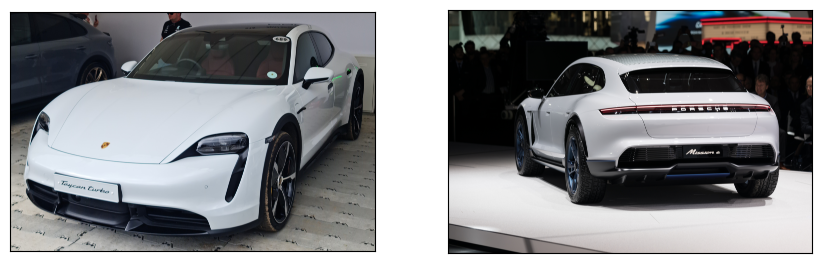

In [ ]:
# show sources
from llama_index.core.response.notebook_utils import display_source_node

for text_node in response.metadata["text_nodes"]:
    display_source_node(text_node, source_length=200)
plot_images(
    [n.metadata["file_path"] for n in response.metadata["image_nodes"]]
)